In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
import zipfile
with zipfile.ZipFile('/content/knn.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/eeg/')

In [ ]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from scipy.interpolate import griddata


Creating csv files dont run again if you already have the files

In [312]:
import re, os
path= '/content/kde/test'

all_text = []
files = []

for filename in os.listdir(path):
      files.append(os.path.join(path, filename))
      continue

for file in files:
    with open(file) as f:
        lines = f.readlines()
        macro_avg_reg = re.compile('(.*)macro avg(.*)')
        run_time_reg = re.compile('(.*)running time in seconds:(.*)')

        temp = []
        for line in lines:
            matches_avg = (macro_avg_reg.match(line))
            matches_run = run_time_reg.match(line)

            if matches_avg:
                #print('Match found: ', matches_avg.group())
                all = matches_avg.group().split()[2:]

                kmeans_value_reg = re.compile('(.*)_kmeans_\d*')
                pca_value_reg = re.compile('(.*)_pca_\d*')
                bandwidth_value_reg = re.compile('(.*)_bandwidth_\d*.\d*')

                precision = (float(all[0]))
                recall = (float(all[1]))
                f1_score = (float(all[2]))
                kmeans = int(kmeans_value_reg.match(file).group()[-4:])
                pca = int(pca_value_reg.match(file).group()[-4:])
                bandwidth = float(bandwidth_value_reg.match(file).group()[-5:])
                temp.append([kmeans, pca, bandwidth, precision, recall, f1_score])
            if matches_run:
                #print('Match found: ', matches_run.group())
                runtime = float(matches_run.group().split()[-1])
                temp[0].append(runtime)
        all_text.append(temp[0][:])

all_data_df = pd.DataFrame(data=all_text)
all_data_df = all_data_df.sort_values(by=[0,1,2], ascending=True)
#print(all_data_df.head())
all_data_df.to_csv('kde_test.csv', index=False, header=False, sep=' ')

In [313]:
path = '/content/knn/train'

all_text = []
files = []

for filename in os.listdir(path):
      files.append(os.path.join(path, filename))
      continue

for file in files:
    with open(file) as f:
        lines = f.readlines()
        macro_avg_reg = re.compile('(.*)macro avg(.*)')
        run_time_reg = re.compile('(.*)running time in seconds:(.*)')

        temp = []
        for line in lines:
            matches_avg = (macro_avg_reg.match(line))
            matches_run = run_time_reg.match(line)

            if matches_avg:
                #print('Match found: ', matches_avg.group())
                all = matches_avg.group().split()[2:]

                kmeans_value_reg = re.compile('(.*)_kmeans_\d*')
                pca_value_reg = re.compile('(.*)_pca_\d*')
                K_value_reg = re.compile('(.*)_K_\d*.\d*')

                precision = (float(all[0]))
                recall = (float(all[1]))
                f1_score = (float(all[2]))
                kmeans = int(kmeans_value_reg.match(file).group()[-4:])
                pca = int(pca_value_reg.match(file).group()[-4:])
                K = float(K_value_reg.match(file).group()[-4:])
                temp.append([kmeans, pca, K, precision, recall, f1_score])
            if matches_run:
                #print('Match found: ', matches_run.group())
                runtime = float(matches_run.group().split()[-1])
                temp[0].append(runtime)
        all_text.append(temp[0][:])

all_data_df = pd.DataFrame(data=all_text)
all_data_df = all_data_df.sort_values(by=[0,1,2], ascending=True)
#print(all_data_df.head())
all_data_df.to_csv('knn_train.csv', index=False, header=False, sep=' ')


In [314]:
path= '/content/eeg/kde/'

all_text = []
files = []

test_train='test'

binary_or_multy = re.compile('(.*)multi-class(.*)\.txt')
for patient in os.listdir(path):
  for filename in os.listdir(os.path.join(path, patient, test_train)):
    if binary_or_multy.match(filename):
        files.append(os.path.join(path,patient,test_train, filename))
        continue

for file in files:
    with open(file) as f:
        #print(file)
        lines = f.readlines()
        macro_avg_reg = re.compile('(.*)macro avg(.*)')
        run_time_reg = re.compile('(.*)running time in seconds:(.*)')

        temp = []
        for line in lines:
            matches_avg = (macro_avg_reg.match(line))
            matches_run = run_time_reg.match(line)

            if matches_avg:
                #print('Match found: ', matches_avg.group())
                all = matches_avg.group().split()[2:]

                kmeans_value_reg = re.compile('(.*)_kmeans_\d*')
                pca_value_reg = re.compile('(.*)\d*_band')
                bandwidth_or_K_value_reg = re.compile('(.*)_bandwidth_\d*.\d*')
                patient_reg = re.compile('(.*)chb\d*')

                precision = (float(all[0]))
                recall = (float(all[1]))
                f1_score = (float(all[2]))
                kmeans = int(kmeans_value_reg.match(file).group()[-4:])
                pca = int(pca_value_reg.match(file).group()[-7:-5])
                bandwidth_or_K = float(bandwidth_or_K_value_reg.match(file).group()[-5:])
                patient = patient_reg.match(file).group()[-5:]
                temp.append([patient, kmeans, pca, bandwidth_or_K, precision, recall, f1_score])
            if matches_run:
                #print('Match found: ', matches_run.group())
                runtime = float(matches_run.group().split()[-1])
                temp[0].append(runtime)
        all_text.append(temp[0][:])

all_data_df = pd.DataFrame(data=all_text)
all_data_df = all_data_df.sort_values(by=[0,1,2,3], ascending=True)
#print(all_data_df)
all_data_df.to_csv('eeg_multi_kde_test.csv', index=False, header=False, sep=' ')
#'patient_id', 'PCA_components', 'binary_or_multiclass'

In [315]:
path= '/content/eeg/knn/'

all_text = []
files = []

test_train='test'

binary_or_multy = re.compile('(.*)binary(.*)\.txt')
for patient in os.listdir(path):
  for filename in os.listdir(os.path.join(path, patient, test_train)):
    if binary_or_multy.match(filename):
        files.append(os.path.join(path,patient,test_train, filename))
        continue

for file in files:
    with open(file) as f:
        #print(file)
        lines = f.readlines()
        macro_avg_reg = re.compile('(.*)macro avg(.*)')
        run_time_reg = re.compile('(.*)running time in seconds:(.*)')

        temp = []
        for line in lines:
            matches_avg = (macro_avg_reg.match(line))
            matches_run = run_time_reg.match(line)

            if matches_avg:
                #print('Match found: ', matches_avg.group())
                all = matches_avg.group().split()[2:]

                kmeans_value_reg = re.compile('(.*)_kmeans_\d*')
                pca_value_reg = re.compile('(.*)\d*_K_')
                bandwidth_or_K_value_reg = re.compile('(.*)_K_\d*')
                patient_reg = re.compile('(.*)chb\d*')

                precision = (float(all[0]))
                recall = (float(all[1]))
                f1_score = (float(all[2]))
                kmeans = int(kmeans_value_reg.match(file).group()[-4:])
                pca = int(pca_value_reg.match(file).group()[-5:-3])
                bandwidth_or_K = float(bandwidth_or_K_value_reg.match(file).group()[-3:])
                patient = patient_reg.match(file).group()[-5:]
                temp.append([patient, kmeans, pca, bandwidth_or_K, precision, recall, f1_score])
            if matches_run:
                #print('Match found: ', matches_run.group())
                runtime = float(matches_run.group().split()[-1])
                temp[0].append(runtime)
        all_text.append(temp[0][:])

all_data_df = pd.DataFrame(data=all_text)
all_data_df = all_data_df.sort_values(by=[0,1,2,3], ascending=True)
#print(all_data_df)
all_data_df.to_csv('eeg_bin_knn_test.csv', index=False, header=False, sep=' ')
#'patient_id', 'PCA_components'

# Kernel Density Estimation


## Digit dataset

In [ ]:
def read_digit_data(file_path, variable='bandwidth'):
    df = pd.read_csv(file_path, sep=' ', header=None)     #macro avg
    df.columns = ['kmeans', 'PCA_components', variable, 'precision', 'recall', 'f1-score', 'runtime']
    return df

df_kde_test = read_digit_data("/content/kde_test.csv")
df_kde_test.head()

,kmeans,PCA_components,bandwidth,precision,recall,f1-score,runtime
0,0,37,0.1,0.94,0.91,0.92,3.608
1,0,37,0.2,0.97,0.97,0.97,3.501
2,0,37,0.5,0.97,0.97,0.97,3.338
3,0,37,1.0,0.97,0.97,0.97,3.233
4,0,37,2.0,0.92,0.91,0.92,3.321


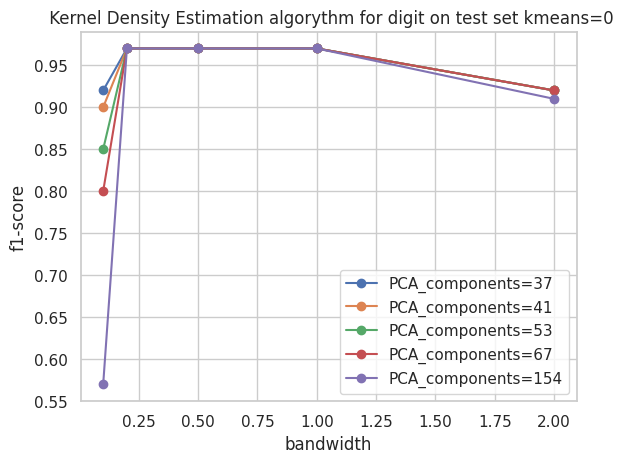

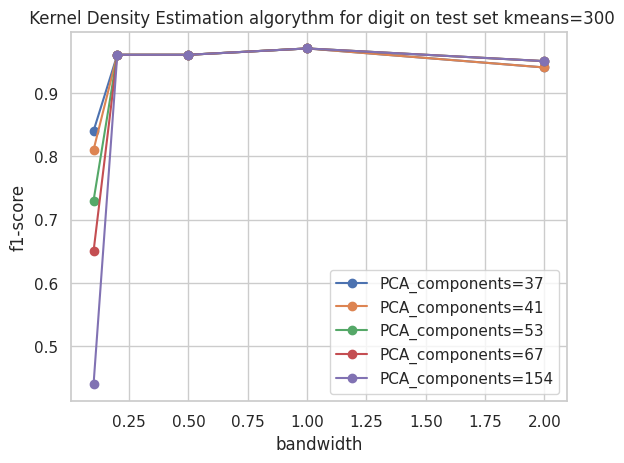

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_digit_f1_score_vs_bandwidth_diff_pca(df, title):
    sns.set(style="whitegrid")
    for kmean in df['kmeans'].unique():
      kmeans_subset_df = df[df['kmeans'] == kmean]
      for PCA_components in kmeans_subset_df['PCA_components'].unique():
          subset_df = kmeans_subset_df[kmeans_subset_df['PCA_components'] == PCA_components]

          plt.plot(subset_df[subset_df.columns[2]], subset_df['f1-score'], label=f'PCA_components={PCA_components}', marker='o')

      plt.xlabel(subset_df.columns[2])
      plt.ylabel('f1-score')
      plt.title(title+' kmeans='+str(kmean))

      plt.legend(title='PCA_components')
      plt.legend(loc='lower right')
      plt.show()

plot_digit_f1_score_vs_bandwidth_diff_pca(df_kde_test,' Kernel Density Estimation algorythm for digit on test set')


In [ ]:
df_kde_train = read_digit_data("/content/kde_train.csv")
df_kde_train.head()

,kmeans,PCA_components,bandwidth,precision,recall,f1-score,runtime
0,0,37,0.1,1.00,1.00,1.00,17.761
1,0,37,0.2,1.00,1.00,1.00,16.717
2,0,37,0.5,1.00,1.00,1.00,15.581
3,0,37,1.0,1.00,1.00,1.00,15.668
4,0,37,2.0,0.93,0.92,0.92,15.474


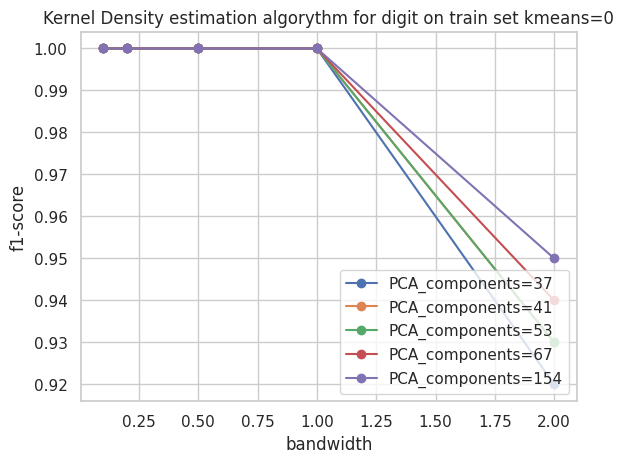

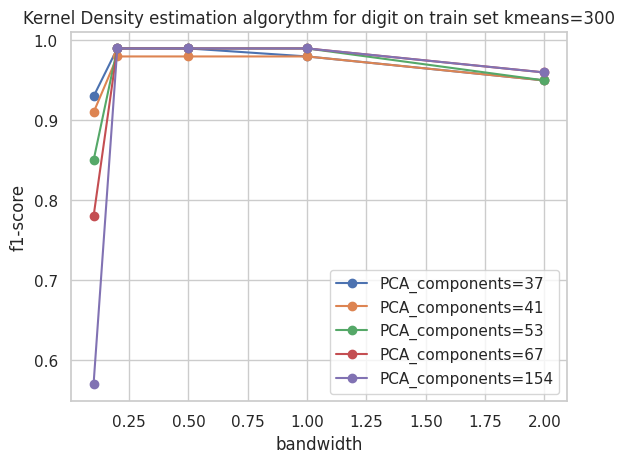

In [ ]:
plot_digit_f1_score_vs_bandwidth_diff_pca(df_kde_train, 'Kernel Density estimation algorythm for digit on train set')



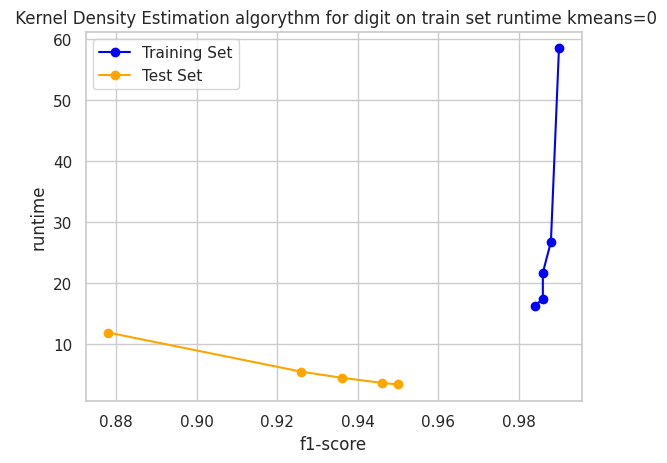

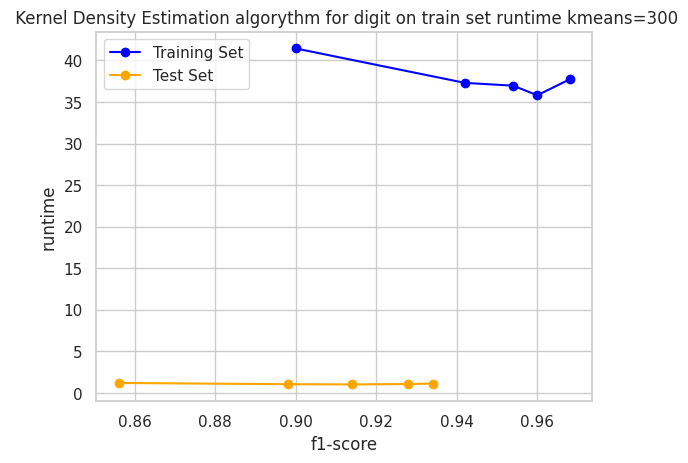

In [ ]:
def plot_digit_runtime_vs_f1_train_vs_test(df_train, df_test, title):
    sns.set(style="whitegrid")
    for kmean in df_train['kmeans'].unique():
      kmeans_subset_df_train = df_train[df_train['kmeans'] == kmean][['PCA_components','runtime', 'f1-score']]
      kmeans_subset_df_test = df_test[df_test['kmeans'] == kmean][['PCA_components','runtime', 'f1-score']]
      grouped_train = kmeans_subset_df_train.groupby('PCA_components')
      grouped_test = kmeans_subset_df_test.groupby('PCA_components')
      plt.plot(grouped_train.mean()['f1-score'], grouped_train.mean()['runtime'],label=f'Training Set', marker='o', color='blue')
      plt.plot(grouped_test.mean()['f1-score'], grouped_test.mean()['runtime'],label=f'Test Set', marker='o', color='orange')

      plt.xlabel('f1-score')
      plt.ylabel('runtime')
      plt.title(title+' kmeans='+str(kmean))
      plt.legend()
      plt.show()

plot_digit_runtime_vs_f1_train_vs_test(df_kde_train,df_kde_test,' Kernel Density Estimation algorythm for digit on train set runtime')


In [ ]:
def plot_test_vs_train_digit(df_test, df_train, title):
    '''
    for kmean in df_train['kmeans'].unique():
      kmeans_train_subset = df_train[df_train["kmeans"] == kmean]
      kmeans_test_subset = df_test[df_test["kmeans"] == kmean]


      for PCA_components in kmeans_train_subset['PCA_components'].unique():
          train_subset = kmeans_train_subset[kmeans_train_subset["PCA_components"] == PCA_components]
          test_subset = kmeans_test_subset[kmeans_test_subset["PCA_components"] == PCA_components]

          plt.plot(train_subset[train_subset.columns[2]], train_subset["f1-score"], label=f'Training Set pca={PCA_components}', marker='o', color='blue')

          plt.plot(test_subset[test_subset.columns[2]], test_subset["f1-score"], label=f'Test Set pca={PCA_components}', marker='o', color='orange')

      plt.xlabel(kmeans_train_subset.columns[2])
      plt.ylabel('f1-score')
      plt.title(title +' kmean='+str(kmean))

      plt.legend()
      plt.show()
      '''

    #avg
    for kmean in df_train['kmeans'].unique():
      kmeans_train_subset = df_train[df_train["kmeans"] == kmean]
      kmeans_test_subset = df_test[df_test["kmeans"] == kmean]


      grouped_train = kmeans_train_subset.groupby('PCA_components')
      grouped_test = kmeans_test_subset.groupby('PCA_components')
      #print(grouped_train.mean().index)
      plt.plot(list(grouped_train.mean().index), grouped_train.mean()['f1-score'], label=f'Training Set', marker='o', color='blue')
      plt.plot(list(grouped_test.mean().index), grouped_test.mean()['f1-score'], label=f'Test Set', marker='o', color='orange')

      plt.xlabel('PCA_components')
      plt.ylabel('f1-score')
      plt.title(title +' kmean='+str(kmean))

      plt.legend()
      plt.show()






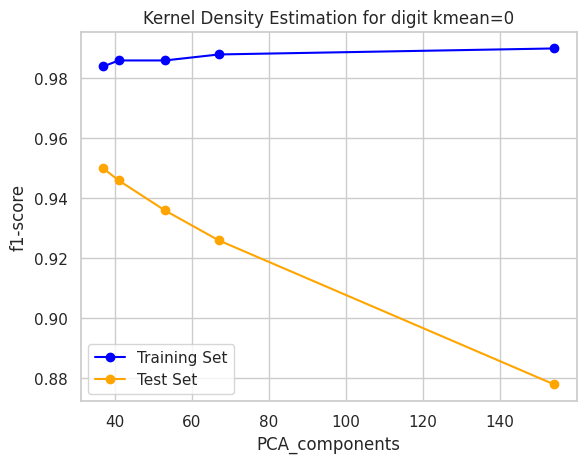

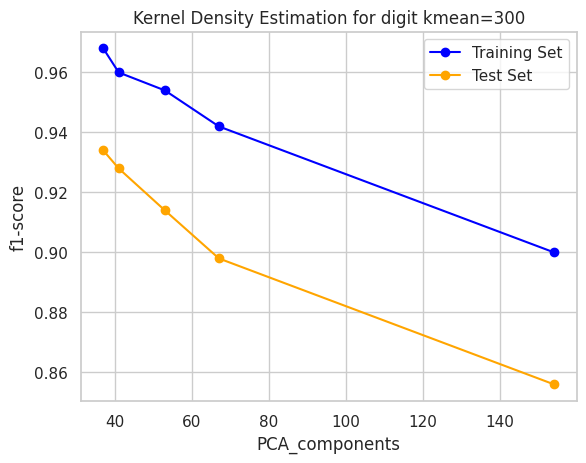

In [ ]:
plot_test_vs_train_digit(df_kde_test, df_kde_train, 'Kernel Density Estimation for digit')

## UC13 binary

In [ ]:
def read_uc13_data(path, value='bandwidth'):
    df = pd.read_csv(path, sep=' ', header=None)
    df.columns = ['patient', 'kmeans', 'pca', value, 'precision', 'recall', 'f1-score','runtime']
    return df

df_uc13_bin_kde_test = read_uc13_data('/content/eeg_bin_kde_test.csv')
df_uc13_bin_kde_test.head()

,patient,kmeans,pca,bandwidth,precision,recall,f1-score,runtime
0,chb03,0,14,0.1,0.00,0.50,0.00,37.565
1,chb03,0,14,0.2,0.50,0.60,0.18,36.625
2,chb03,0,14,0.5,0.54,0.85,0.56,37.613
3,chb03,0,14,1.0,0.56,0.58,0.57,37.173
4,chb03,0,14,2.0,0.53,0.59,0.54,37.499


In [ ]:
df_uc13_bin_kde_train = read_uc13_data('/content/eeg_bin_kde_train.csv')
df_uc13_bin_kde_train.head()

,patient,kmeans,pca,bandwidth,precision,recall,f1-score,runtime
0,chb03,0,14,0.1,1.0,1.0,1.0,74.827
1,chb03,0,14,0.2,1.0,1.0,1.0,75.808
2,chb03,0,14,0.5,1.0,1.0,1.0,76.607
3,chb03,0,14,1.0,1.0,1.0,1.0,74.658
4,chb03,0,14,2.0,1.0,1.0,1.0,75.657


In [ ]:
import plotly.graph_objects as go
import numpy as np
from scipy.interpolate import griddata

def plot_uc13_3d_kmeans_k_or_bandwidth_avg_f1_score(df, title):
    k_or_bandwidth = df.columns[3]
    average_df = df.groupby(['kmeans',k_or_bandwidth], as_index=False)['f1-score'].mean()

    kmeans = np.unique(average_df['kmeans'])
    k_or_b = np.unique(average_df[k_or_bandwidth])
    kmeans, k_or_b = np.meshgrid(kmeans, k_or_b)

    Z = griddata((average_df['kmeans'], average_df[k_or_bandwidth]), average_df['f1-score'],(kmeans, k_or_b), method='cubic')


    fig = go.Figure(go.Surface(x=kmeans,y=k_or_b,z=Z))

    fig.update_layout(scene=dict(
                        xaxis_title='kmeans',
                        yaxis_title=k_or_bandwidth,
                        zaxis_title='Average F1-Score'),
                        scene_camera=dict(up=dict(x=0, y=0, z=1),
                        center=dict(x=0, y=0, z=0),
                        eye=dict(x=1.25, y=1.25, z=1.25)))

    fig.update_layout(title=title)
    fig.show()


def plot_uc13_2d_kmeans_avg_f1_score(df, title):
    #print(df)
    k_or_bandwidth = df.columns[3]
    average_df = df.groupby(['kmeans',k_or_bandwidth], as_index=False)['f1-score'].mean()
    for k_or_b in np.unique(average_df[k_or_bandwidth]):
      subset_df = average_df[average_df[k_or_bandwidth] == k_or_b]

      plt.plot(subset_df['kmeans'], subset_df['f1-score'], label=f'{k_or_bandwidth}={k_or_b}', marker='o')

    plt.xlabel('kmeans')
    plt.ylabel('f1-score')
    plt.title(title)

    plt.legend(title=k_or_bandwidth)
    plt.legend(loc='lower right')
    plt.show()

def plot_uc13_2d_kmeans_fix_k_or_bandwidth_each_patient_avg_f1_score(df, k_or_b=2, title=''):
    k_or_bandwidth = df.columns[3]
    df = df[df[k_or_bandwidth] == k_or_b]
    average_df = df.groupby(['patient','kmeans'], as_index=False)['f1-score'].mean()
    #print(average_df)
    for patient_id in np.unique(average_df['patient']):
      subset_df = average_df[average_df['patient'] == patient_id]

      plt.plot(subset_df['kmeans'], subset_df['f1-score'], label=f'patient_id={patient_id}', marker='o')

    plt.xlabel('Kmeans')
    plt.ylabel('f1-score')
    plt.title(title)

    plt.legend(title='patient')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
    plt.show()


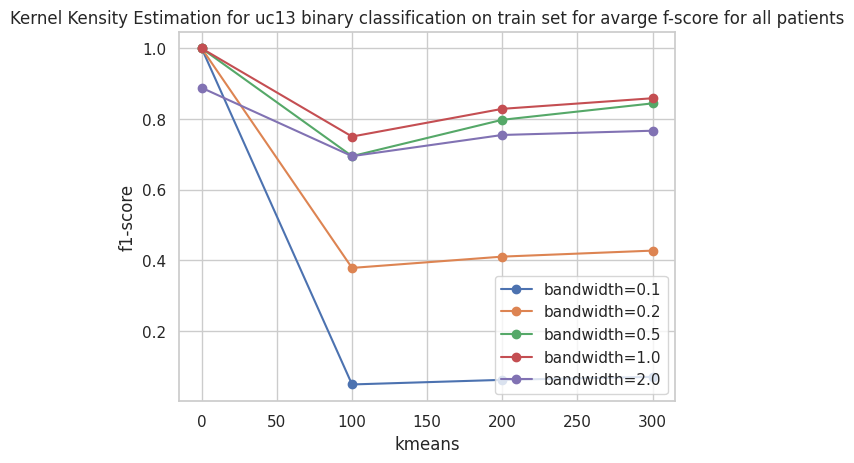

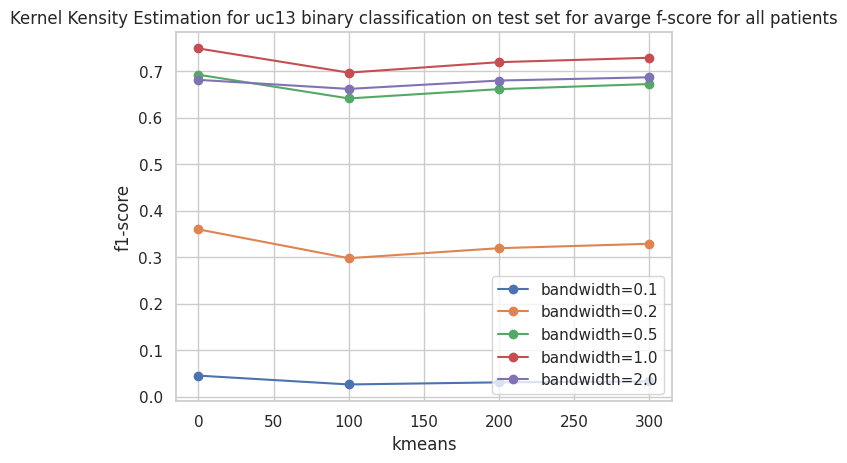

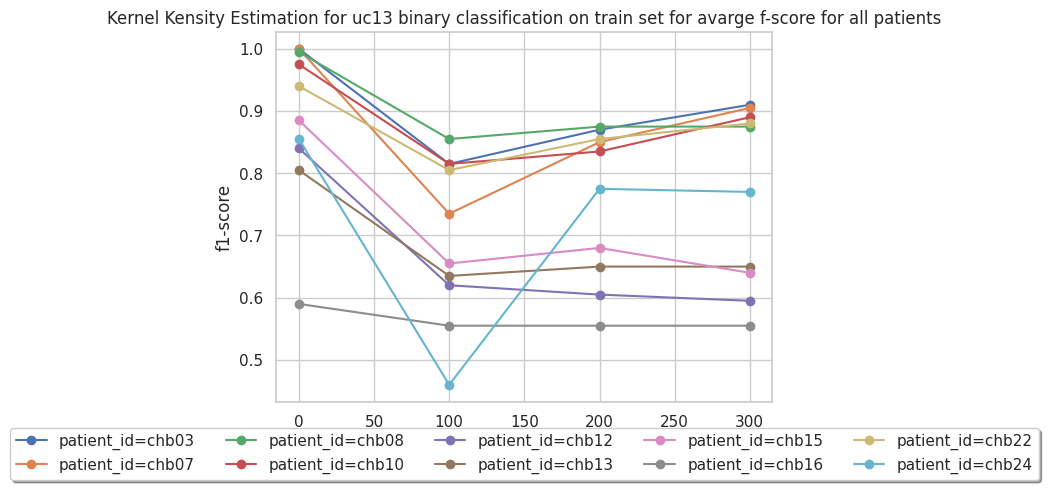

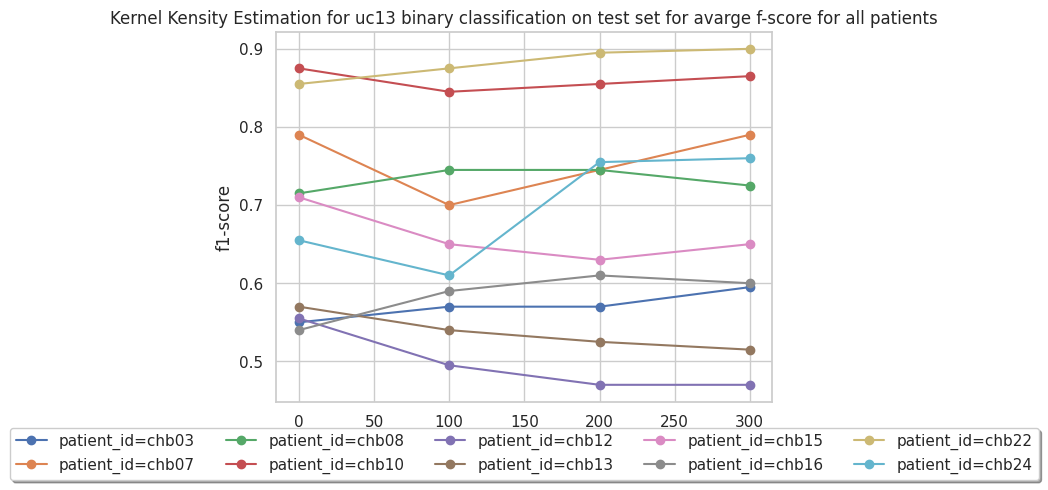

In [ ]:
plot_uc13_3d_kmeans_k_or_bandwidth_avg_f1_score(df_uc13_bin_kde_train, 'Kernel Kensity Estimation for uc13 binary classification on train set for avarge f-score for all patients')
plot_uc13_3d_kmeans_k_or_bandwidth_avg_f1_score(df_uc13_bin_kde_test, 'Kernel Kensity Estimation for uc13 binary classification on test set for avarge f-score for all patients')
plot_uc13_2d_kmeans_avg_f1_score(df_uc13_bin_kde_train, 'Kernel Kensity Estimation for uc13 binary classification on train set for avarge f-score for all patients')
plot_uc13_2d_kmeans_avg_f1_score(df_uc13_bin_kde_test, 'Kernel Kensity Estimation for uc13 binary classification on test set for avarge f-score for all patients')
plot_uc13_2d_kmeans_fix_k_or_bandwidth_each_patient_avg_f1_score(df_uc13_bin_kde_train, 2,'Kernel Kensity Estimation for uc13 binary classification on train set for avarge f-score for all patients')
plot_uc13_2d_kmeans_fix_k_or_bandwidth_each_patient_avg_f1_score(df_uc13_bin_kde_test, 2, 'Kernel Kensity Estimation for uc13 binary classification on test set for avarge f-score for all patients')


## UC13 Multi

In [ ]:
df_uc13_multi_kde_test = read_uc13_data('/content/eeg_multi_kde_test.csv')
df_uc13_multi_kde_train = read_uc13_data('/content/eeg_multi_kde_train.csv')
df_uc13_multi_kde_test.head()
df_uc13_multi_kde_test.head()

,patient,kmeans,pca,bandwidth,precision,recall,f1-score,runtime
0,chb03,0,14,0.1,0.00,0.17,0.00,39.278
1,chb03,0,14,0.2,0.17,0.21,0.07,38.149
2,chb03,0,14,0.5,0.21,0.30,0.20,37.981
3,chb03,0,14,1.0,0.21,0.21,0.21,37.721
4,chb03,0,14,2.0,0.22,0.23,0.21,38.058


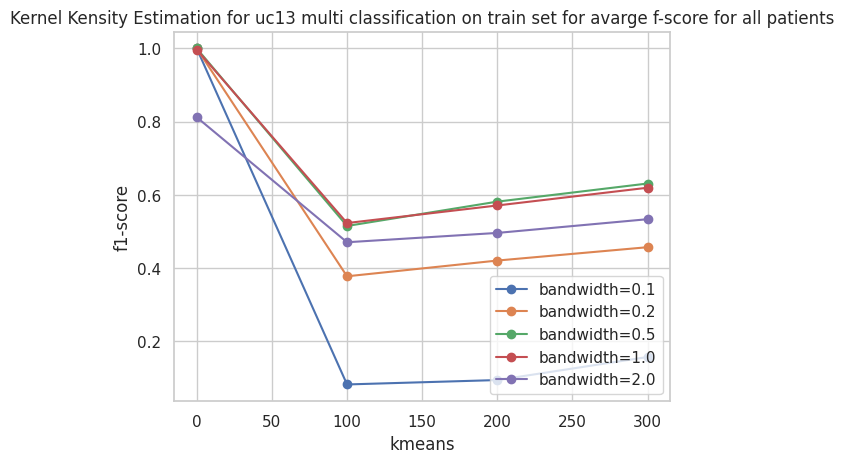

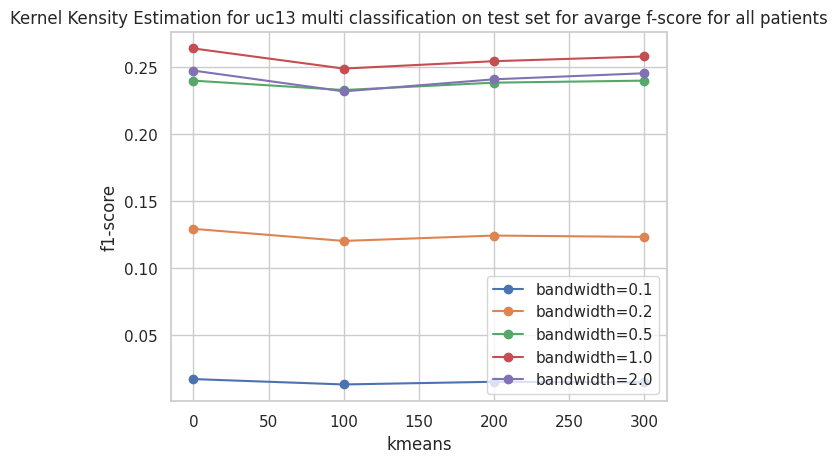

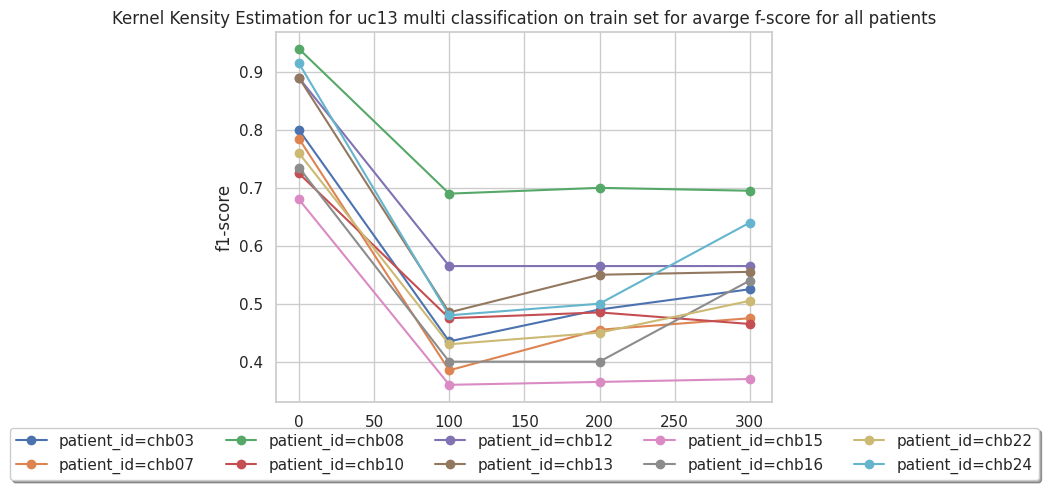

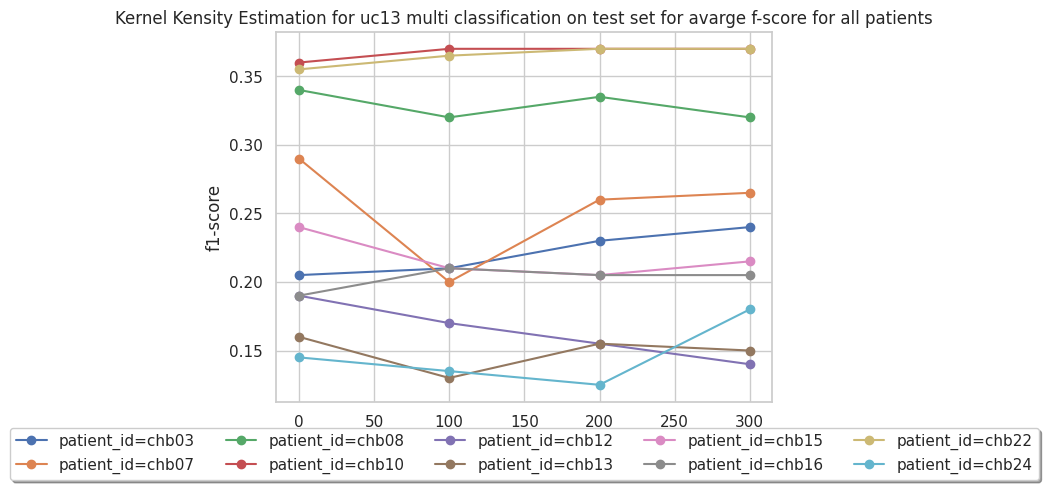

In [ ]:
plot_uc13_3d_kmeans_k_or_bandwidth_avg_f1_score(df_uc13_multi_kde_train, 'Kernel Kensity Estimation for uc13 multi classification on train set for avarge f-score for all patients')
plot_uc13_3d_kmeans_k_or_bandwidth_avg_f1_score(df_uc13_multi_kde_test, 'Kernel Kensity Estimation for uc13 multi classification on test set for avarge f-score for all patients')
plot_uc13_2d_kmeans_avg_f1_score(df_uc13_multi_kde_train, 'Kernel Kensity Estimation for uc13 multi classification on train set for avarge f-score for all patients')
plot_uc13_2d_kmeans_avg_f1_score(df_uc13_multi_kde_test, 'Kernel Kensity Estimation for uc13 multi classification on test set for avarge f-score for all patients')
plot_uc13_2d_kmeans_fix_k_or_bandwidth_each_patient_avg_f1_score(df_uc13_multi_kde_train, 2,'Kernel Kensity Estimation for uc13 multi classification on train set for avarge f-score for all patients')
plot_uc13_2d_kmeans_fix_k_or_bandwidth_each_patient_avg_f1_score(df_uc13_multi_kde_test, 2,'Kernel Kensity Estimation for uc13 multi classification on test set for avarge f-score for all patients')


#KNN

## Digit dataset

In [ ]:
df_knn_test = read_digit_data("/content/knn_test.csv", 'K')
df_knn_test.head()

,kmeans,PCA_components,K,precision,recall,f1-score,runtime
0,0,37,3.0,0.98,0.97,0.97,4.266
1,0,37,5.0,0.97,0.97,0.97,4.273
2,0,37,7.0,0.97,0.97,0.97,4.233
3,0,37,9.0,0.97,0.97,0.97,4.605
4,0,37,11.0,0.97,0.97,0.97,4.688


In [ ]:
df_knn_train = read_digit_data("/content/knn_train.csv", 'K')
df_knn_train.head()

,kmeans,PCA_components,K,precision,recall,f1-score,runtime
0,0,37,3.0,0.99,0.99,0.99,22.430
1,0,37,5.0,0.99,0.99,0.99,22.021
2,0,37,7.0,0.98,0.98,0.98,22.713
3,0,37,9.0,0.98,0.98,0.98,23.372
4,0,37,11.0,0.98,0.98,0.98,24.875


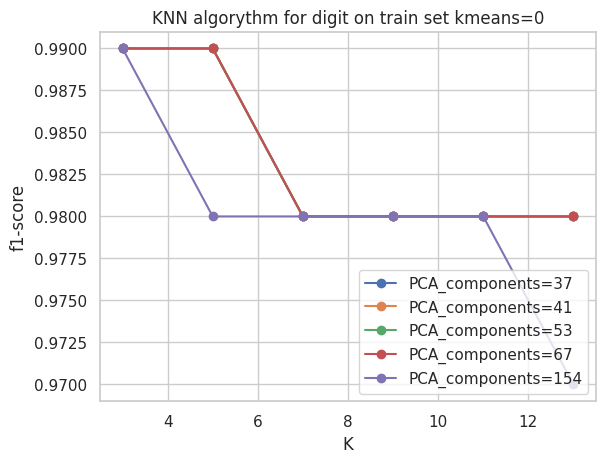

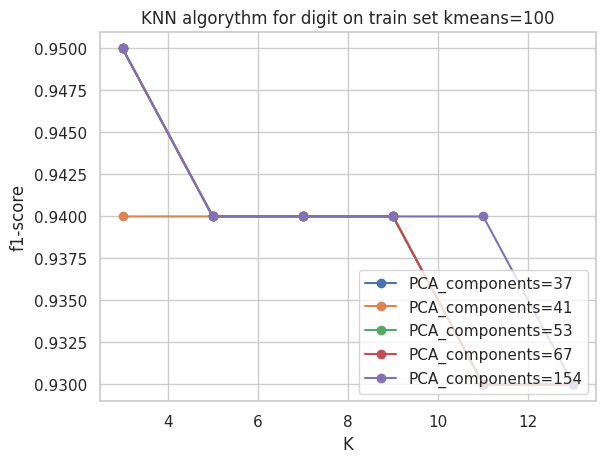

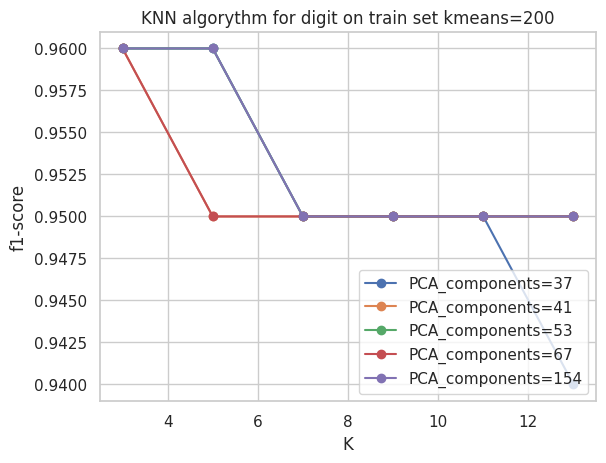

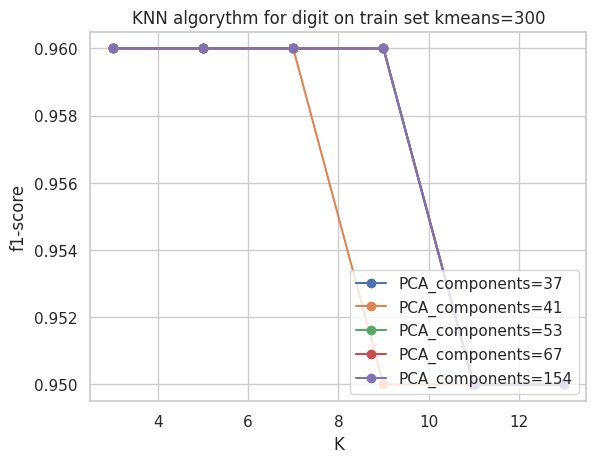

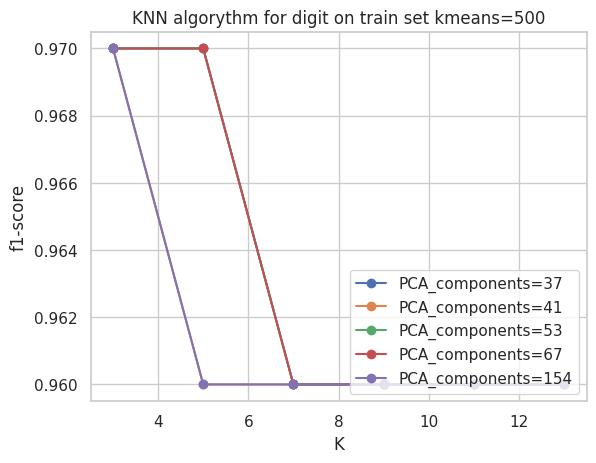

In [ ]:
plot_digit_f1_score_vs_bandwidth_diff_pca(df_knn_train, 'KNN algorythm for digit on train set')


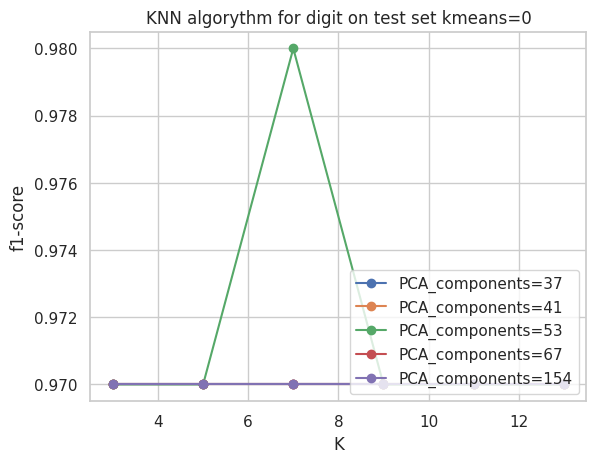

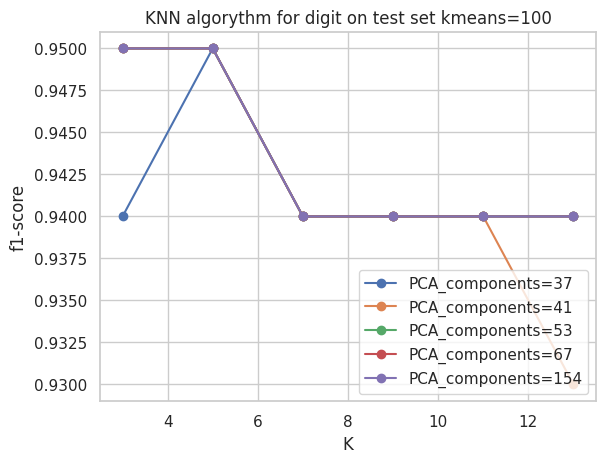

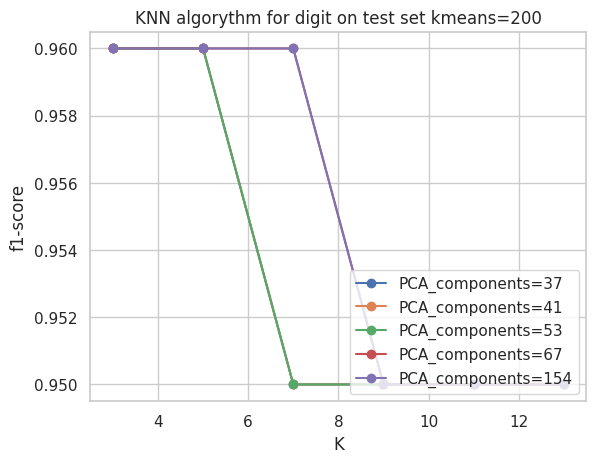

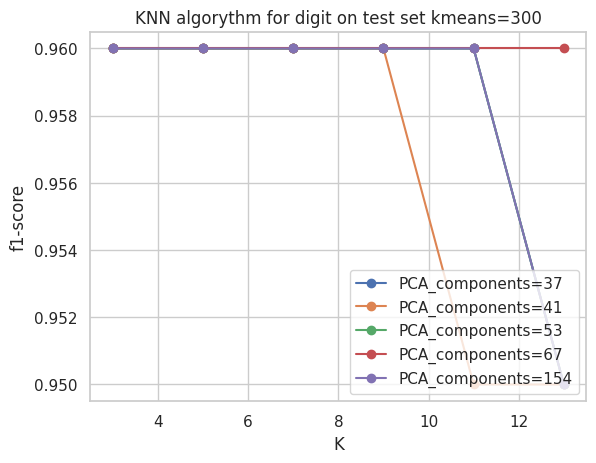

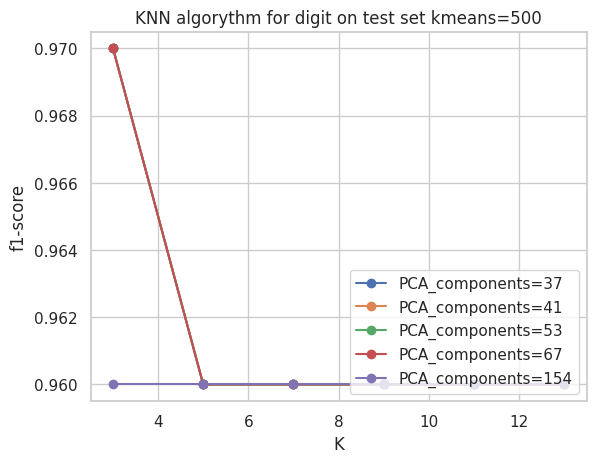

In [ ]:
plot_digit_f1_score_vs_bandwidth_diff_pca(df_knn_test, 'KNN algorythm for digit on test set')


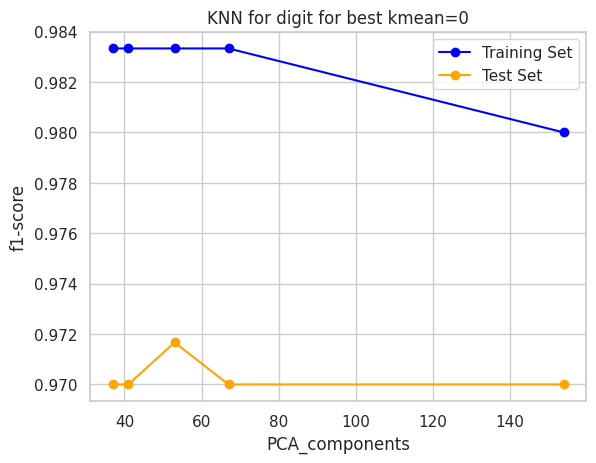

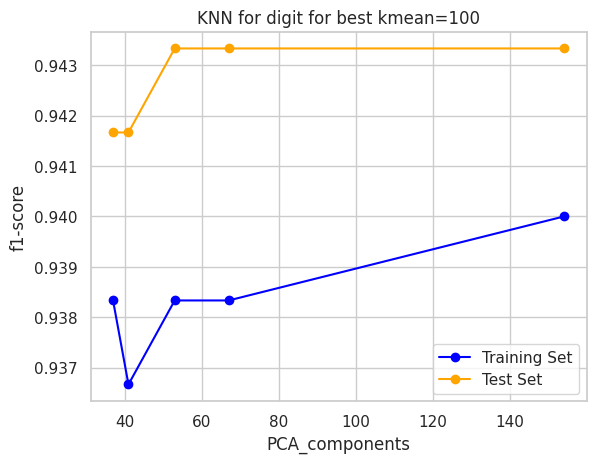

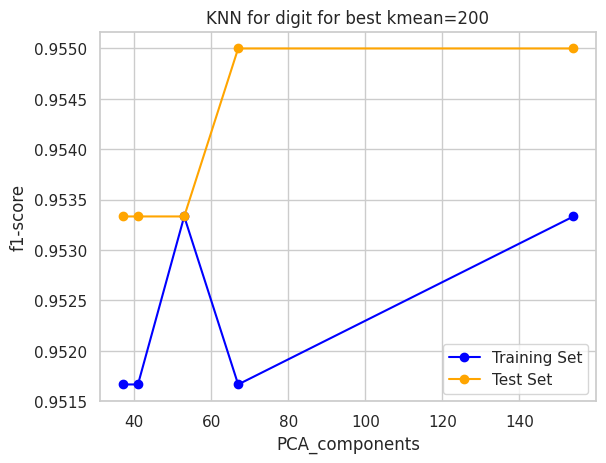

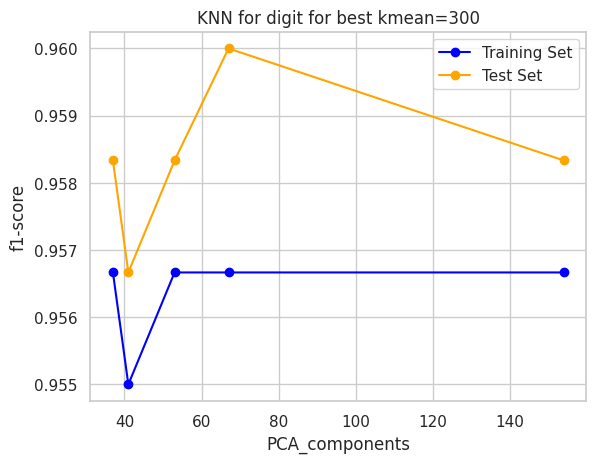

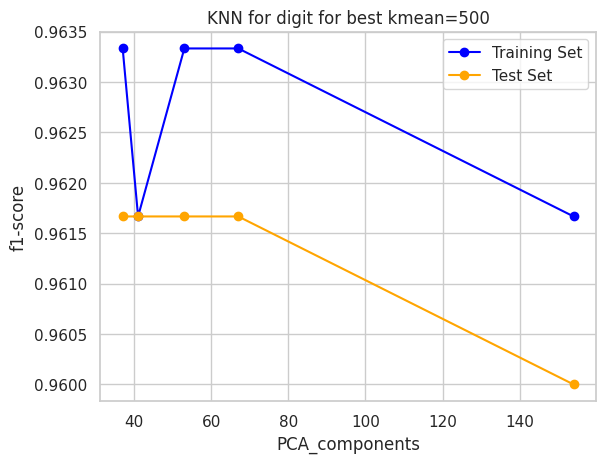

In [ ]:
plot_test_vs_train_digit(df_knn_test, df_knn_train, 'KNN for digit for best')


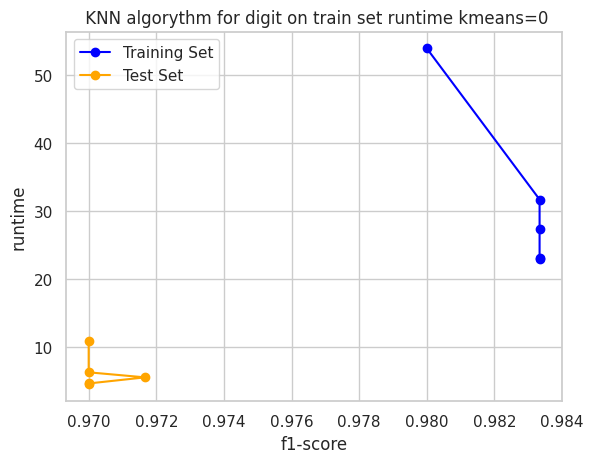

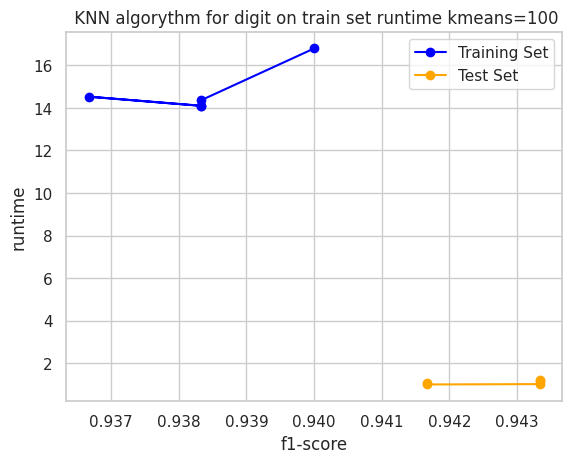

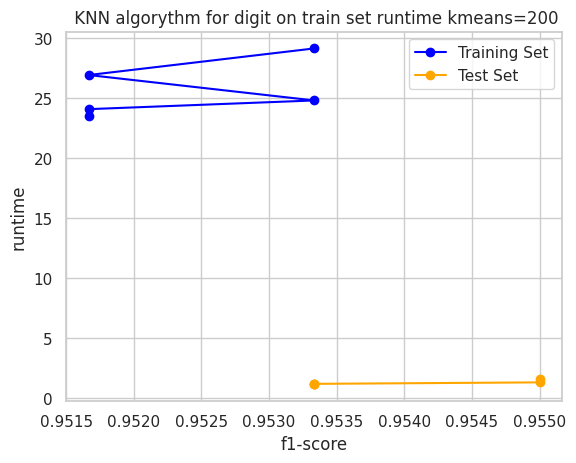

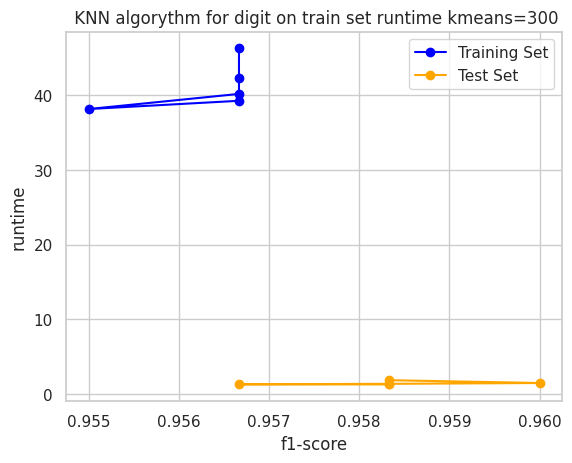

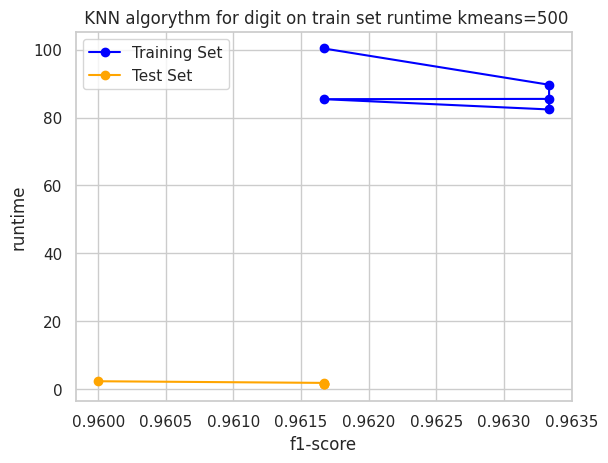

In [ ]:
plot_digit_runtime_vs_f1_train_vs_test(df_knn_train, df_knn_test,' KNN algorythm for digit on train set runtime')


## UC13 binary

In [ ]:
df_uc13_bin_knn_train = read_uc13_data('/content/eeg_bin_knn_train.csv', 'K')
df_uc13_bin_knn_test = read_uc13_data('/content/eeg_bin_knn_test.csv', 'K')
df_uc13_bin_knn_train.head()

,patient,kmeans,pca,K,precision,recall,f1-score,runtime
0,chb03,0,14,3.0,1.00,0.98,0.99,47.957
1,chb03,0,14,5.0,0.99,0.98,0.98,49.117
2,chb03,0,14,7.0,0.99,0.96,0.97,47.601
3,chb03,0,14,9.0,0.99,0.96,0.97,47.781
4,chb03,0,14,11.0,0.99,0.96,0.97,47.291


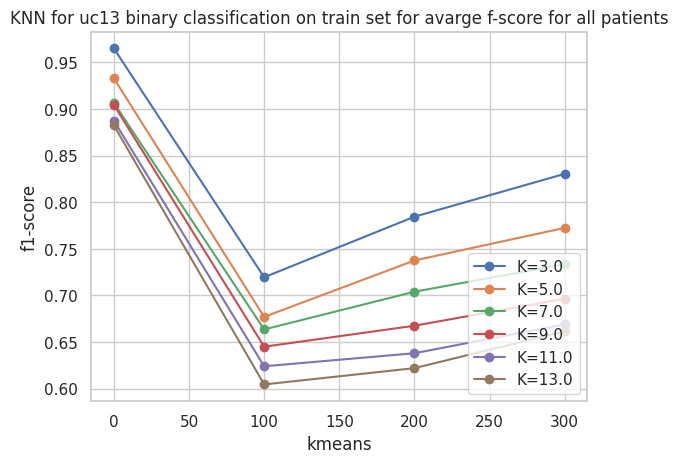

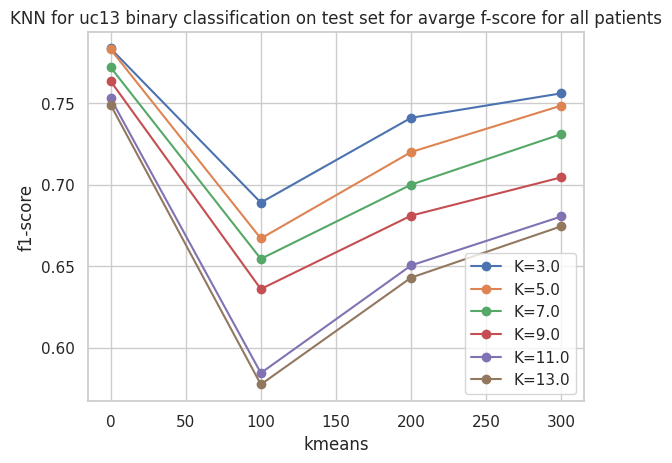

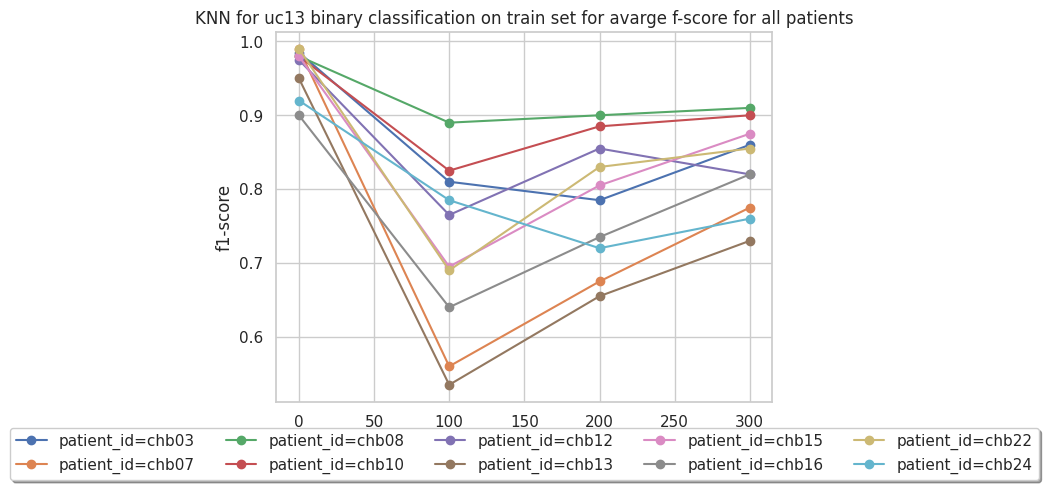

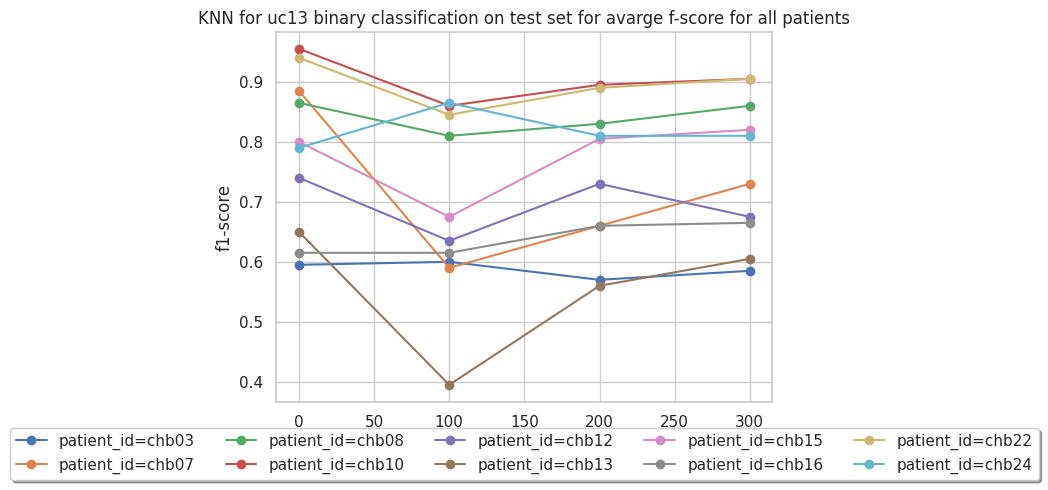

In [ ]:
plot_uc13_3d_kmeans_k_or_bandwidth_avg_f1_score(df_uc13_bin_knn_train, 'KNN for uc13 binary classification on train set for avarge f-score for all patients')
plot_uc13_3d_kmeans_k_or_bandwidth_avg_f1_score(df_uc13_bin_knn_test, 'KNN for uc13 binary classification on test set for avarge f-score for all patients')
plot_uc13_2d_kmeans_avg_f1_score(df_uc13_bin_knn_train, 'KNN for uc13 binary classification on train set for avarge f-score for all patients')
plot_uc13_2d_kmeans_avg_f1_score(df_uc13_bin_knn_test, 'KNN for uc13 binary classification on test set for avarge f-score for all patients')
plot_uc13_2d_kmeans_fix_k_or_bandwidth_each_patient_avg_f1_score(df_uc13_bin_knn_train, 3,'KNN for uc13 binary classification on train set for avarge f-score for all patients')
plot_uc13_2d_kmeans_fix_k_or_bandwidth_each_patient_avg_f1_score(df_uc13_bin_knn_test, 3,'KNN for uc13 binary classification on test set for avarge f-score for all patients')


## UC13 Multi

In [ ]:
df_uc13_multi_knn_train = read_uc13_data('/content/eeg_multi_knn_train.csv', 'K')
df_uc13_multi_knn_test = read_uc13_data('/content/eeg_multi_knn_test.csv', 'K')
df_uc13_multi_knn_test.head()
df_uc13_multi_knn_test.head()

,patient,kmeans,pca,K,precision,recall,f1-score,runtime
0,chb03,0,14,3.0,0.22,0.19,0.19,25.814
1,chb03,0,14,5.0,0.22,0.19,0.19,26.176
2,chb03,0,14,7.0,0.22,0.19,0.19,26.421
3,chb03,0,14,9.0,0.22,0.19,0.19,26.116
4,chb03,0,14,11.0,0.22,0.19,0.19,25.342


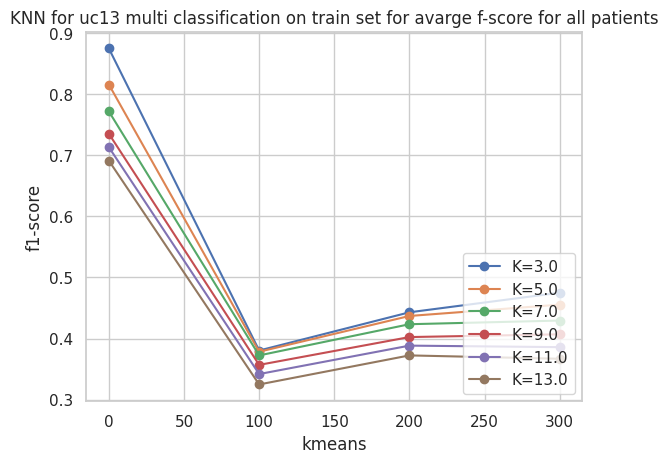

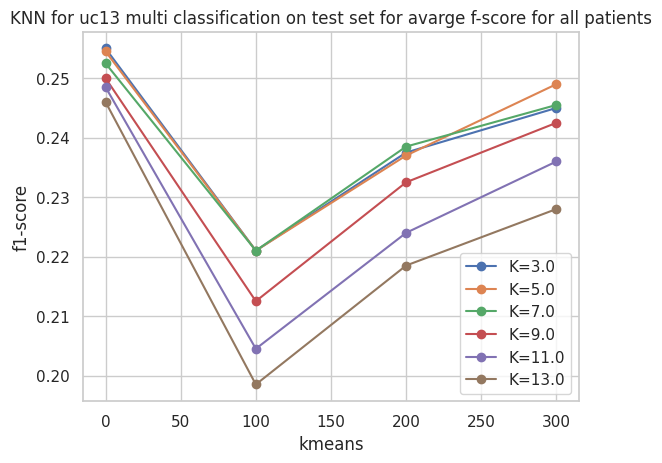

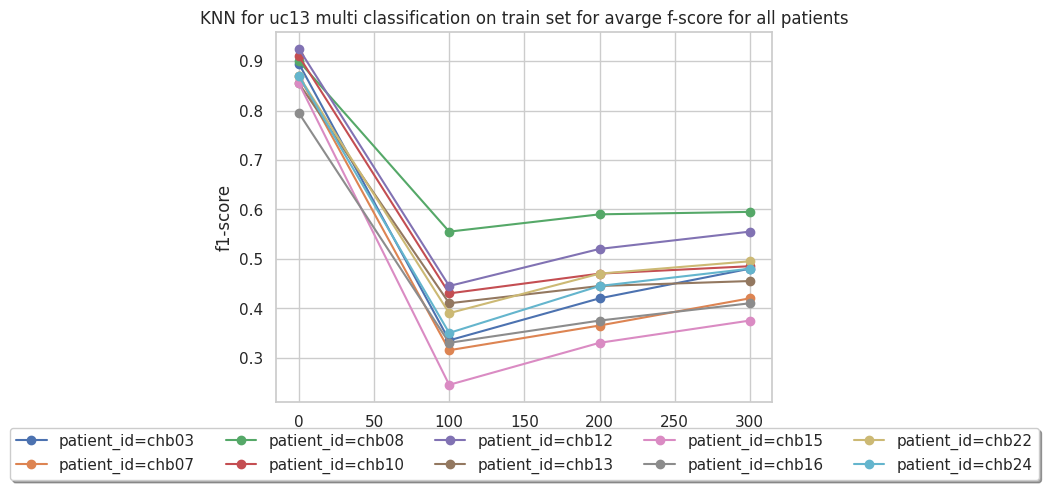

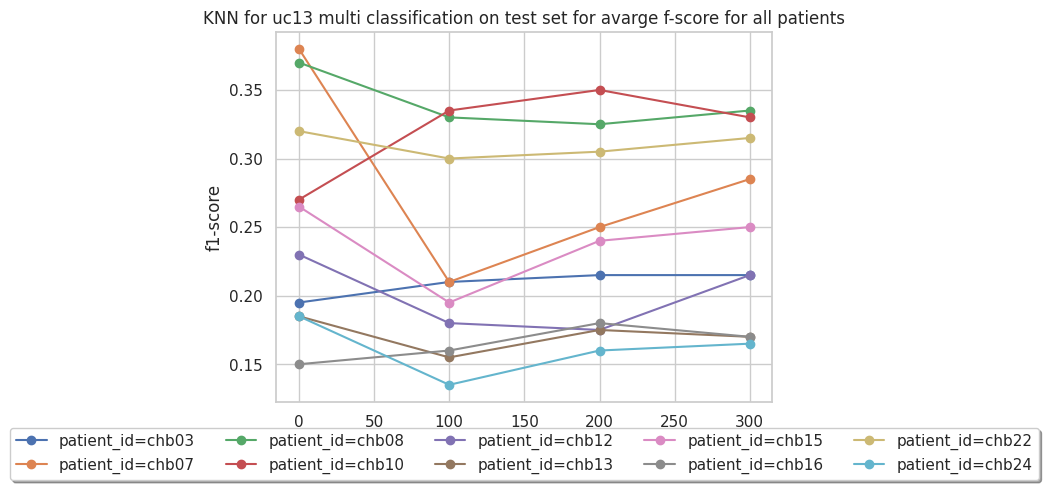

In [ ]:
plot_uc13_3d_kmeans_k_or_bandwidth_avg_f1_score(df_uc13_multi_knn_train, 'KNN for uc13 multi classification on train set for avarge f-score for all patients')
plot_uc13_3d_kmeans_k_or_bandwidth_avg_f1_score(df_uc13_multi_knn_test, 'KNN for uc13 multi classification on test set for avarge f-score for all patients')
plot_uc13_2d_kmeans_avg_f1_score(df_uc13_multi_knn_train, 'KNN for uc13 multi classification on train set for avarge f-score for all patients')
plot_uc13_2d_kmeans_avg_f1_score(df_uc13_multi_knn_test, 'KNN for uc13 multi classification on test set for avarge f-score for all patients')
plot_uc13_2d_kmeans_fix_k_or_bandwidth_each_patient_avg_f1_score(df_uc13_multi_knn_train, 3,'KNN for uc13 multi classification on train set for avarge f-score for all patients')
plot_uc13_2d_kmeans_fix_k_or_bandwidth_each_patient_avg_f1_score(df_uc13_multi_knn_test, 3,'KNN for uc13 multi classification on test set for avarge f-score for all patients')
